In [ ]:
# reading in files from google drive to speed up run time
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Load packages

> Indented block



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  plot_tree

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Phase3-Project-Data/df_master_people_crashes_2018_2023.csv")

In [ ]:
df['Total_Serious_Injuries']=df['INJURIES_FATAL_c']+df['INJURIES_INCAPACITATING_c']
df['Has_Serious_Injury']=df['Total_Serious_Injuries'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
# dropping junk column
df.drop(columns=(['Unnamed: 0']), inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318659 entries, 0 to 1318658
Data columns (total 35 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PERSON_ID_p                1318659 non-null  object 
 1   CRASH_RECORD_ID            1318659 non-null  object 
 2   VEHICLE_ID_p               1291471 non-null  float64
 3   CRASH_DATE_p               1318659 non-null  object 
 4   PERSON_TYPE_p              1318659 non-null  object 
 5   SEX_p                      1296738 non-null  object 
 6   AGE_p                      936778 non-null   float64
 7   HOSPITAL_p                 231395 non-null   object 
 8   INJURY_CLASSIFICATION_p    1318202 non-null  object 
 9   DRIVER_ACTION_p            1046639 non-null  object 
 10  DRIVER_VISION_p            1046214 non-null  object 
 11  PHYSICAL_CONDITION_p       1047428 non-null  object 
 12  BAC_RESULT_p               1047186 non-null  object 
 13  BAC_RESULT_V

#Random Value Counts

In [ ]:
df['AGE_p'].value_counts()

 27.0     26295
 26.0     26259
 25.0     26251
 28.0     26056
 29.0     25418
          ...  
 108.0        4
-49.0         1
-177.0        1
-47.0         1
-59.0         1
Name: AGE_p, Length: 115, dtype: int64

In [ ]:
df['AGE_p'].isna().sum()

381881

In [ ]:
df['SEX_p'].isna().sum()

21921

In [ ]:
df['BAC_RESULT_p'].value_counts()

TEST NOT OFFERED                   1031361
TEST REFUSED                         11126
TEST PERFORMED, RESULTS UNKNOWN       2598
TEST TAKEN                            2101
Name: BAC_RESULT_p, dtype: int64

In [ ]:
df['BAC_RESULT_VALUE_p'].value_counts()

0.00    160
0.17    111
0.18    108
0.21     99
0.20     90
0.14     89
0.16     83
0.19     75
0.15     70
0.22     67
0.13     63
0.12     62
0.23     61
0.11     60
0.24     51
0.25     42
0.26     42
0.27     31
0.10     29
0.09     27
0.28     25
0.08     19
0.29     16
0.03     15
0.07     15
0.33     13
0.04     13
0.30     12
0.05     11
0.32      9
0.35      9
0.31      8
0.06      6
0.02      6
0.38      5
0.44      3
0.34      3
0.01      2
0.45      2
0.36      2
1.00      2
0.67      1
0.79      1
0.58      1
0.88      1
0.85      1
0.37      1
0.39      1
0.95      1
0.41      1
0.99      1
0.47      1
0.40      1
0.60      1
0.98      1
Name: BAC_RESULT_VALUE_p, dtype: int64

In [ ]:
df['Has_Serious_Injury'].value_counts()


0    1286402
1      32257
Name: Has_Serious_Injury, dtype: int64

#Baseline Models

In [ ]:
#Function for evaluation metrics
def print_binary_evaluation(X_train, X_test,y_train, y_true, strategy):
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    results_dict = {'accuracy': accuracy_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred),
                    'f1_score': f1_score(y_true, y_pred)}
    return results_dict

In [ ]:
# Seperate features from target
X = df.drop("Has_Serious_Injury", axis=1)
y = df['Has_Serious_Injury']

### Perform Train-Test Split



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

##Most Frequent (Mode)
###By predicting 0 all the time, our model would be ~ 98% acurate.

In [ ]:
print_binary_evaluation(X_train, X_test, y_train, y_test, 'most_frequent')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9757936086633401,
 'recall': 0.0,
 'precision': 0.0,
 'f1_score': 0.0}

In [ ]:
# 0 is obviously the most frequent value
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(list(y_pred))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

##Uniform
## Uniform strategy creates a baseline model that predicts with random uniform distribution. The targets have a similar probability of being a prediction output.



In [ ]:
print_binary_evaluation(X_train, X_test,y_train, y_test, 'uniform')

{'accuracy': 0.5002411538986546,
 'recall': 0.5047619047619047,
 'precision': 0.024437447293862123,
 'f1_score': 0.046617942352539514}

In [ ]:
# Uniform gives us more of a 50/50 split
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(list(y_pred))

[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 

##Stratified
### Stratified strategy creates a baseline model that follows the target distribution. It is suitable for imbalanced data as it reflects the actual distribution.

In [ ]:
print_binary_evaluation(X_train, X_test,y_train, y_test, 'stratified')

{'accuracy': 0.9523425295375608,
 'recall': 0.02593984962406015,
 'precision': 0.02541436464088398,
 'f1_score': 0.025674418604651163}

In [ ]:
# 0 dominates as ~ 98% of our target variable == 0
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(list(y_pred))

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

#Investigating feature target relationships with `dabl`
Documentation: https://dabl.github.io/stable/

In [ ]:
pip install dabl

In [ ]:
import dabl

In [ ]:
data = pd.read_csv(dabl.datasets.data_path("/content/gdrive/MyDrive/Colab Notebooks/Phase3-Project-Data/df_master_people_crashes_2018_2023.csv"))


In [ ]:
data['Total_Serious_Injuries']=data['INJURIES_FATAL_c']+data['INJURIES_INCAPACITATING_c']
data['Has_Serious_Injury']=data['Total_Serious_Injuries'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
data_clean = dabl.clean(data)[::10]

In [ ]:
#IDK if I agree with all these choices but it did get rid of our pesky unanmed column
# Unfortunately it also took our target column lol
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131866 entries, 0 to 1318650
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   PERSON_ID_p                131866 non-null  object  
 1   CRASH_RECORD_ID            131866 non-null  object  
 2   VEHICLE_ID_p               129160 non-null  float64 
 3   CRASH_DATE_p               131866 non-null  object  
 4   PERSON_TYPE_p              131866 non-null  category
 5   SEX_p                      129656 non-null  category
 6   AGE_p                      93824 non-null   float64 
 7   HOSPITAL_p                 23205 non-null   category
 8   INJURY_CLASSIFICATION_p    131822 non-null  category
 9   DRIVER_ACTION_p            104618 non-null  category
 10  DRIVER_VISION_p            104570 non-null  category
 11  PHYSICAL_CONDITION_p       104702 non-null  category
 12  is_driver_p                131866 non-null  category
 13  total_drivers

In [ ]:
data_clean.head()


,PERSON_ID_p,CRASH_RECORD_ID,VEHICLE_ID_p,CRASH_DATE_p,PERSON_TYPE_p,SEX_p,AGE_p,HOSPITAL_p,INJURY_CLASSIFICATION_p,DRIVER_ACTION_p,...,POSTED_SPEED_LIMIT_c,WEATHER_CONDITION_c,LIGHTING_CONDITION_c,ROADWAY_SURFACE_COND_c,ROAD_DEFECT_c,CRASH_TYPE_c,PRIM_CONTRIBUTORY_CAUSE_c,MOST_SEVERE_INJURY_c,INJURIES_TOTAL_c,LOCATION_c
0,O749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,834816.0,2019-09-28 03:30:00,DRIVER,M,25.0,NaN,NO INDICATION OF INJURY,UNKNOWN,...,30,RAIN,DARKNESS,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,POINT (-87.755576950444 41.900042872883)
10,O880096,8f023e80247cc6a21c48af0a66c4c5a22ee82ac2c6e7a9...,834965.0,2020-05-06 10:15:00,DRIVER,X,NaN,NaN,NO INDICATION OF INJURY,UNKNOWN,...,15,CLEAR,DAYLIGHT,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,POINT (-87.690332827362 42.018435448293)
20,O1304802,ad540890753eea75c569779c5b35c5005e5f716aa923ab...,1239156.0,2022-03-25 04:54:00,DRIVER,F,29.0,NaN,NO INDICATION OF INJURY,OTHER,...,30,RAIN,"DARKNESS, LIGHTED ROAD",WET,UNKNOWN,INJURY AND / OR TOW DUE TO CRASH,UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...,NO INDICATION OF INJURY,0.0,POINT (-87.677328562722 41.939473723566)
30,O848714,fc394684791def59859341e54c0b0a538e540858d8d3a6...,805446.0,2020-02-24 00:45:00,DRIVER,M,43.0,NaN,NO INDICATION OF INJURY,DISREGARDED CONTROL DEVICES,...,30,CLEAR,"DARKNESS, LIGHTED ROAD",DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,DISREGARDING TRAFFIC SIGNALS,NO INDICATION OF INJURY,0.0,POINT (-87.663133271804 41.985645031939)
40,O1304819,ea1a51026bd0c49506b352689dbf7ac6250b8e481dbb16...,1239167.0,2022-03-25 06:00:00,DRIVER,X,NaN,NaN,NO INDICATION OF INJURY,UNKNOWN,...,30,CLEAR,DAYLIGHT,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,POINT (-87.699712948707 41.995455351827)


In [ ]:
data_clean['AGE_p'].value_counts()

25.0     2670
27.0     2624
29.0     2598
28.0     2590
24.0     2556
         ... 
98.0        4
100.0       2
101.0       2
105.0       1
99.0        1
Name: AGE_p, Length: 103, dtype: int64

In [ ]:
data_clean['AGE_p'].isna().sum()

38042

In [ ]:
data_clean.columns

Index(['PERSON_ID_p', 'CRASH_RECORD_ID', 'VEHICLE_ID_p', 'CRASH_DATE_p',
       'PERSON_TYPE_p', 'SEX_p', 'AGE_p', 'HOSPITAL_p',
       'INJURY_CLASSIFICATION_p', 'DRIVER_ACTION_p', 'DRIVER_VISION_p',
       'PHYSICAL_CONDITION_p', 'is_driver_p', 'total_drivers_in_crash_p',
       'CRASH_DATE_c', 'CRASH_HOUR_c', 'CRASH_DAY_OF_WEEK_c', 'CRASH_MONTH_c',
       'POSTED_SPEED_LIMIT_c', 'WEATHER_CONDITION_c', 'LIGHTING_CONDITION_c',
       'ROADWAY_SURFACE_COND_c', 'ROAD_DEFECT_c', 'CRASH_TYPE_c',
       'PRIM_CONTRIBUTORY_CAUSE_c', 'MOST_SEVERE_INJURY_c', 'INJURIES_TOTAL_c',
       'LOCATION_c'],
      dtype='object')

In [ ]:
data.columns

Index(['Unnamed: 0', 'PERSON_ID_p', 'CRASH_RECORD_ID', 'VEHICLE_ID_p',
       'CRASH_DATE_p', 'PERSON_TYPE_p', 'SEX_p', 'AGE_p', 'HOSPITAL_p',
       'INJURY_CLASSIFICATION_p', 'DRIVER_ACTION_p', 'DRIVER_VISION_p',
       'PHYSICAL_CONDITION_p', 'BAC_RESULT_p', 'BAC_RESULT_VALUE_p',
       'is_driver_p', 'total_drivers_in_crash_p', 'CRASH_DATE_c',
       'CRASH_HOUR_c', 'CRASH_DAY_OF_WEEK_c', 'CRASH_MONTH_c',
       'POSTED_SPEED_LIMIT_c', 'WEATHER_CONDITION_c', 'LIGHTING_CONDITION_c',
       'ROADWAY_SURFACE_COND_c', 'ROAD_DEFECT_c', 'CRASH_TYPE_c',
       'HIT_AND_RUN_I_c', 'PRIM_CONTRIBUTORY_CAUSE_c', 'MOST_SEVERE_INJURY_c',
       'INJURIES_TOTAL_c', 'INJURIES_FATAL_c', 'INJURIES_INCAPACITATING_c',
       'LOCATION_c', 'Total_Serious_Injuries', 'Has_Serious_Injury'],
      dtype='object')

Target looks like classification


/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning: Dropped 1719 outliers in column INJURIES_TOTAL_c.
  warn("Dropped {} outliers in column {}.".format(
/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning: Dropped 4 outliers in column AGE_p.
  warn("Dropped {} outliers in column {}.".format(


Linear Discriminant Analysis training set score: 0.597


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='Has_Serious_Injury'>,
 [<Figure size 1200x400 with 6 Axes>,
  array([[<Axes: title={'center': '0.511'}, xlabel='INJURIES_TOTAL_c', ylabel='AGE_p'>,
          <Axes: title={'center': '0.510'}, xlabel='INJURIES_TOTAL_c', ylabel='VEHICLE_ID_p'>,
          <Axes: title={'center': '0.508'}, xlabel='INJURIES_TOTAL_c', ylabel='CRASH_HOUR_c(jittered)'>,
          <Axes: title={'center': '0.504'}, xlabel='INJURIES_TOTAL_c', ylabel='CRASH_DAY_OF_WEEK_c(jittered)'>]],
        dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 640x480 with 1 Axes>],
 array([[<Axes: title={'center': 'MOST_SEVERE_INJURY_c'}>,
         <Axes: title={'center': 'INJURY_CLASSIFICATION_p'}>,
         <Axes: title={'center': 'CRASH_TYPE_c'}>,
         <Axes: title={'center': 'HOSPITAL_p'}>,
         <Axes: title={'center': 'PRIM_CONTRIBUTORY_CAUSE_c'}>],
        [<Axes: title={'center': 'PERSON_TYPE_p'}>,
         <Axes: title={'cent

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


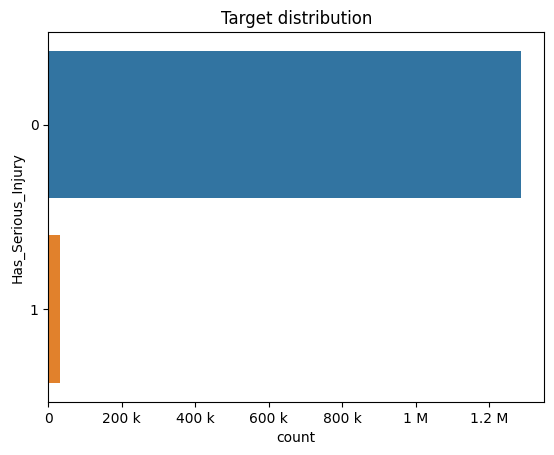

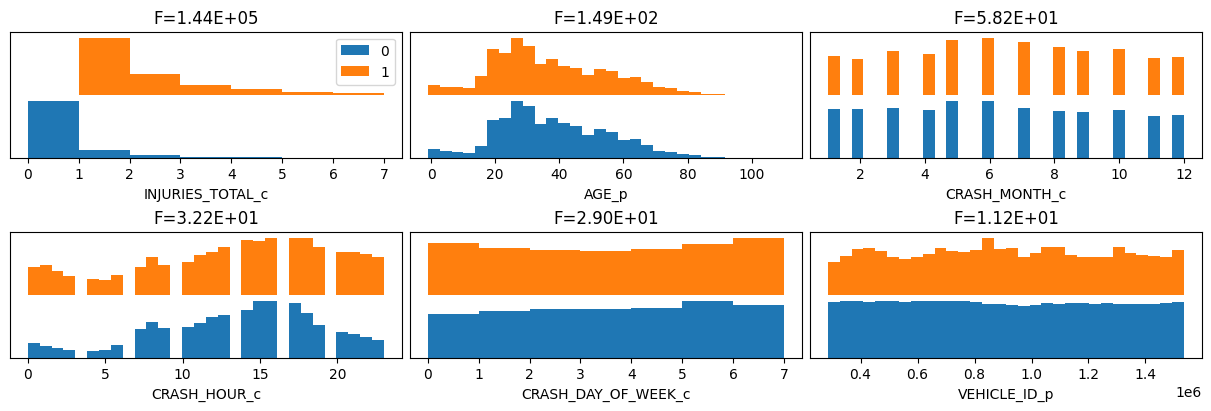

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


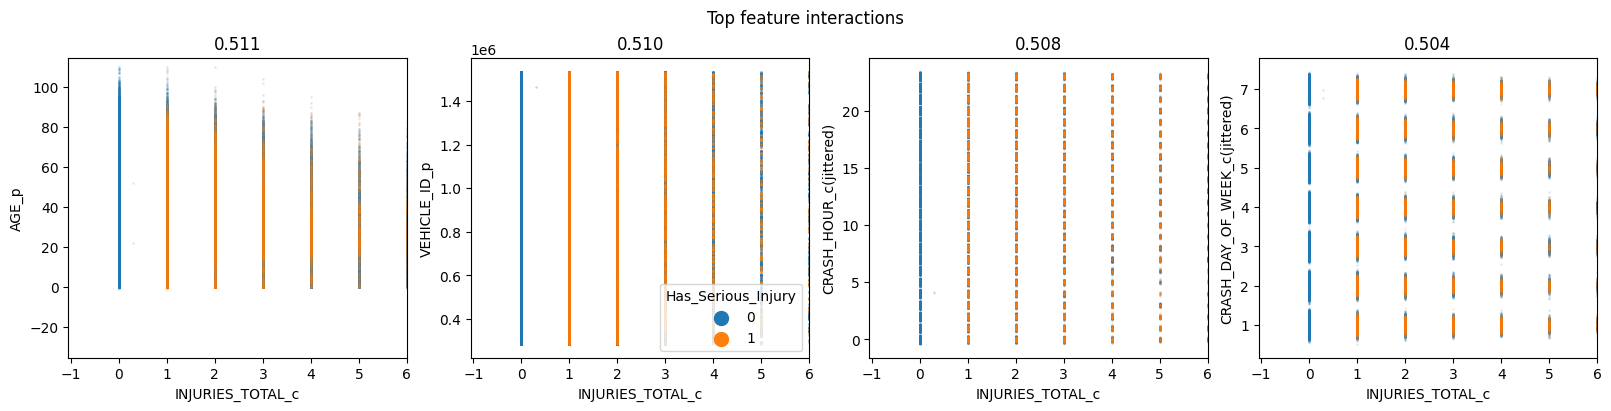

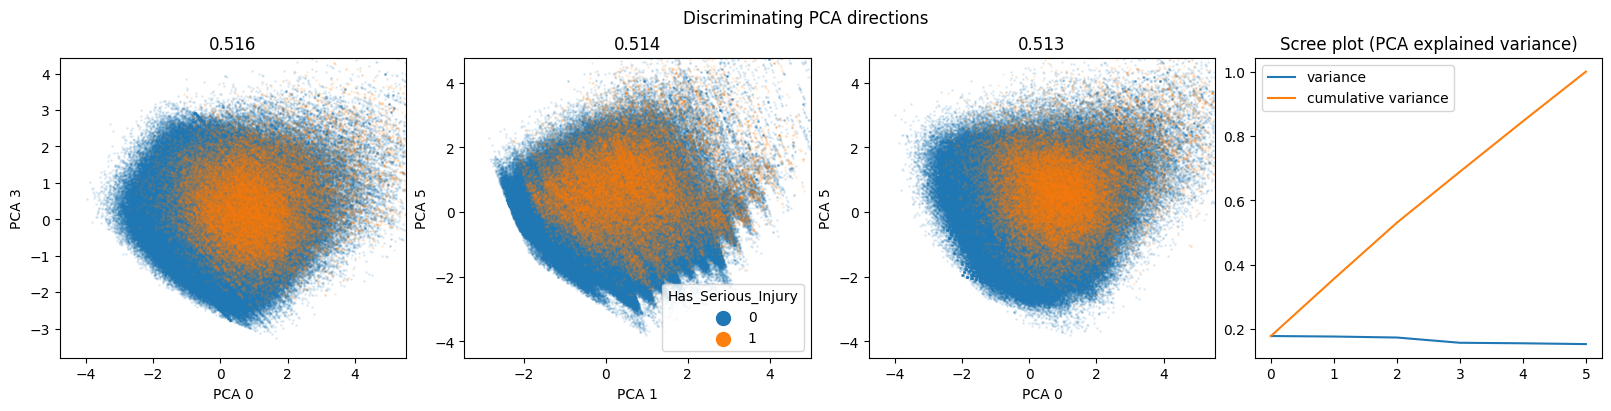

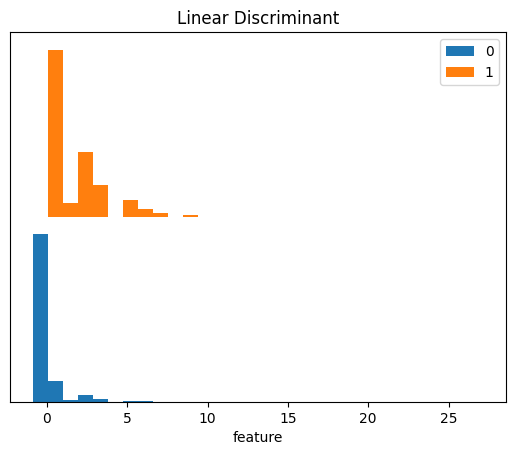

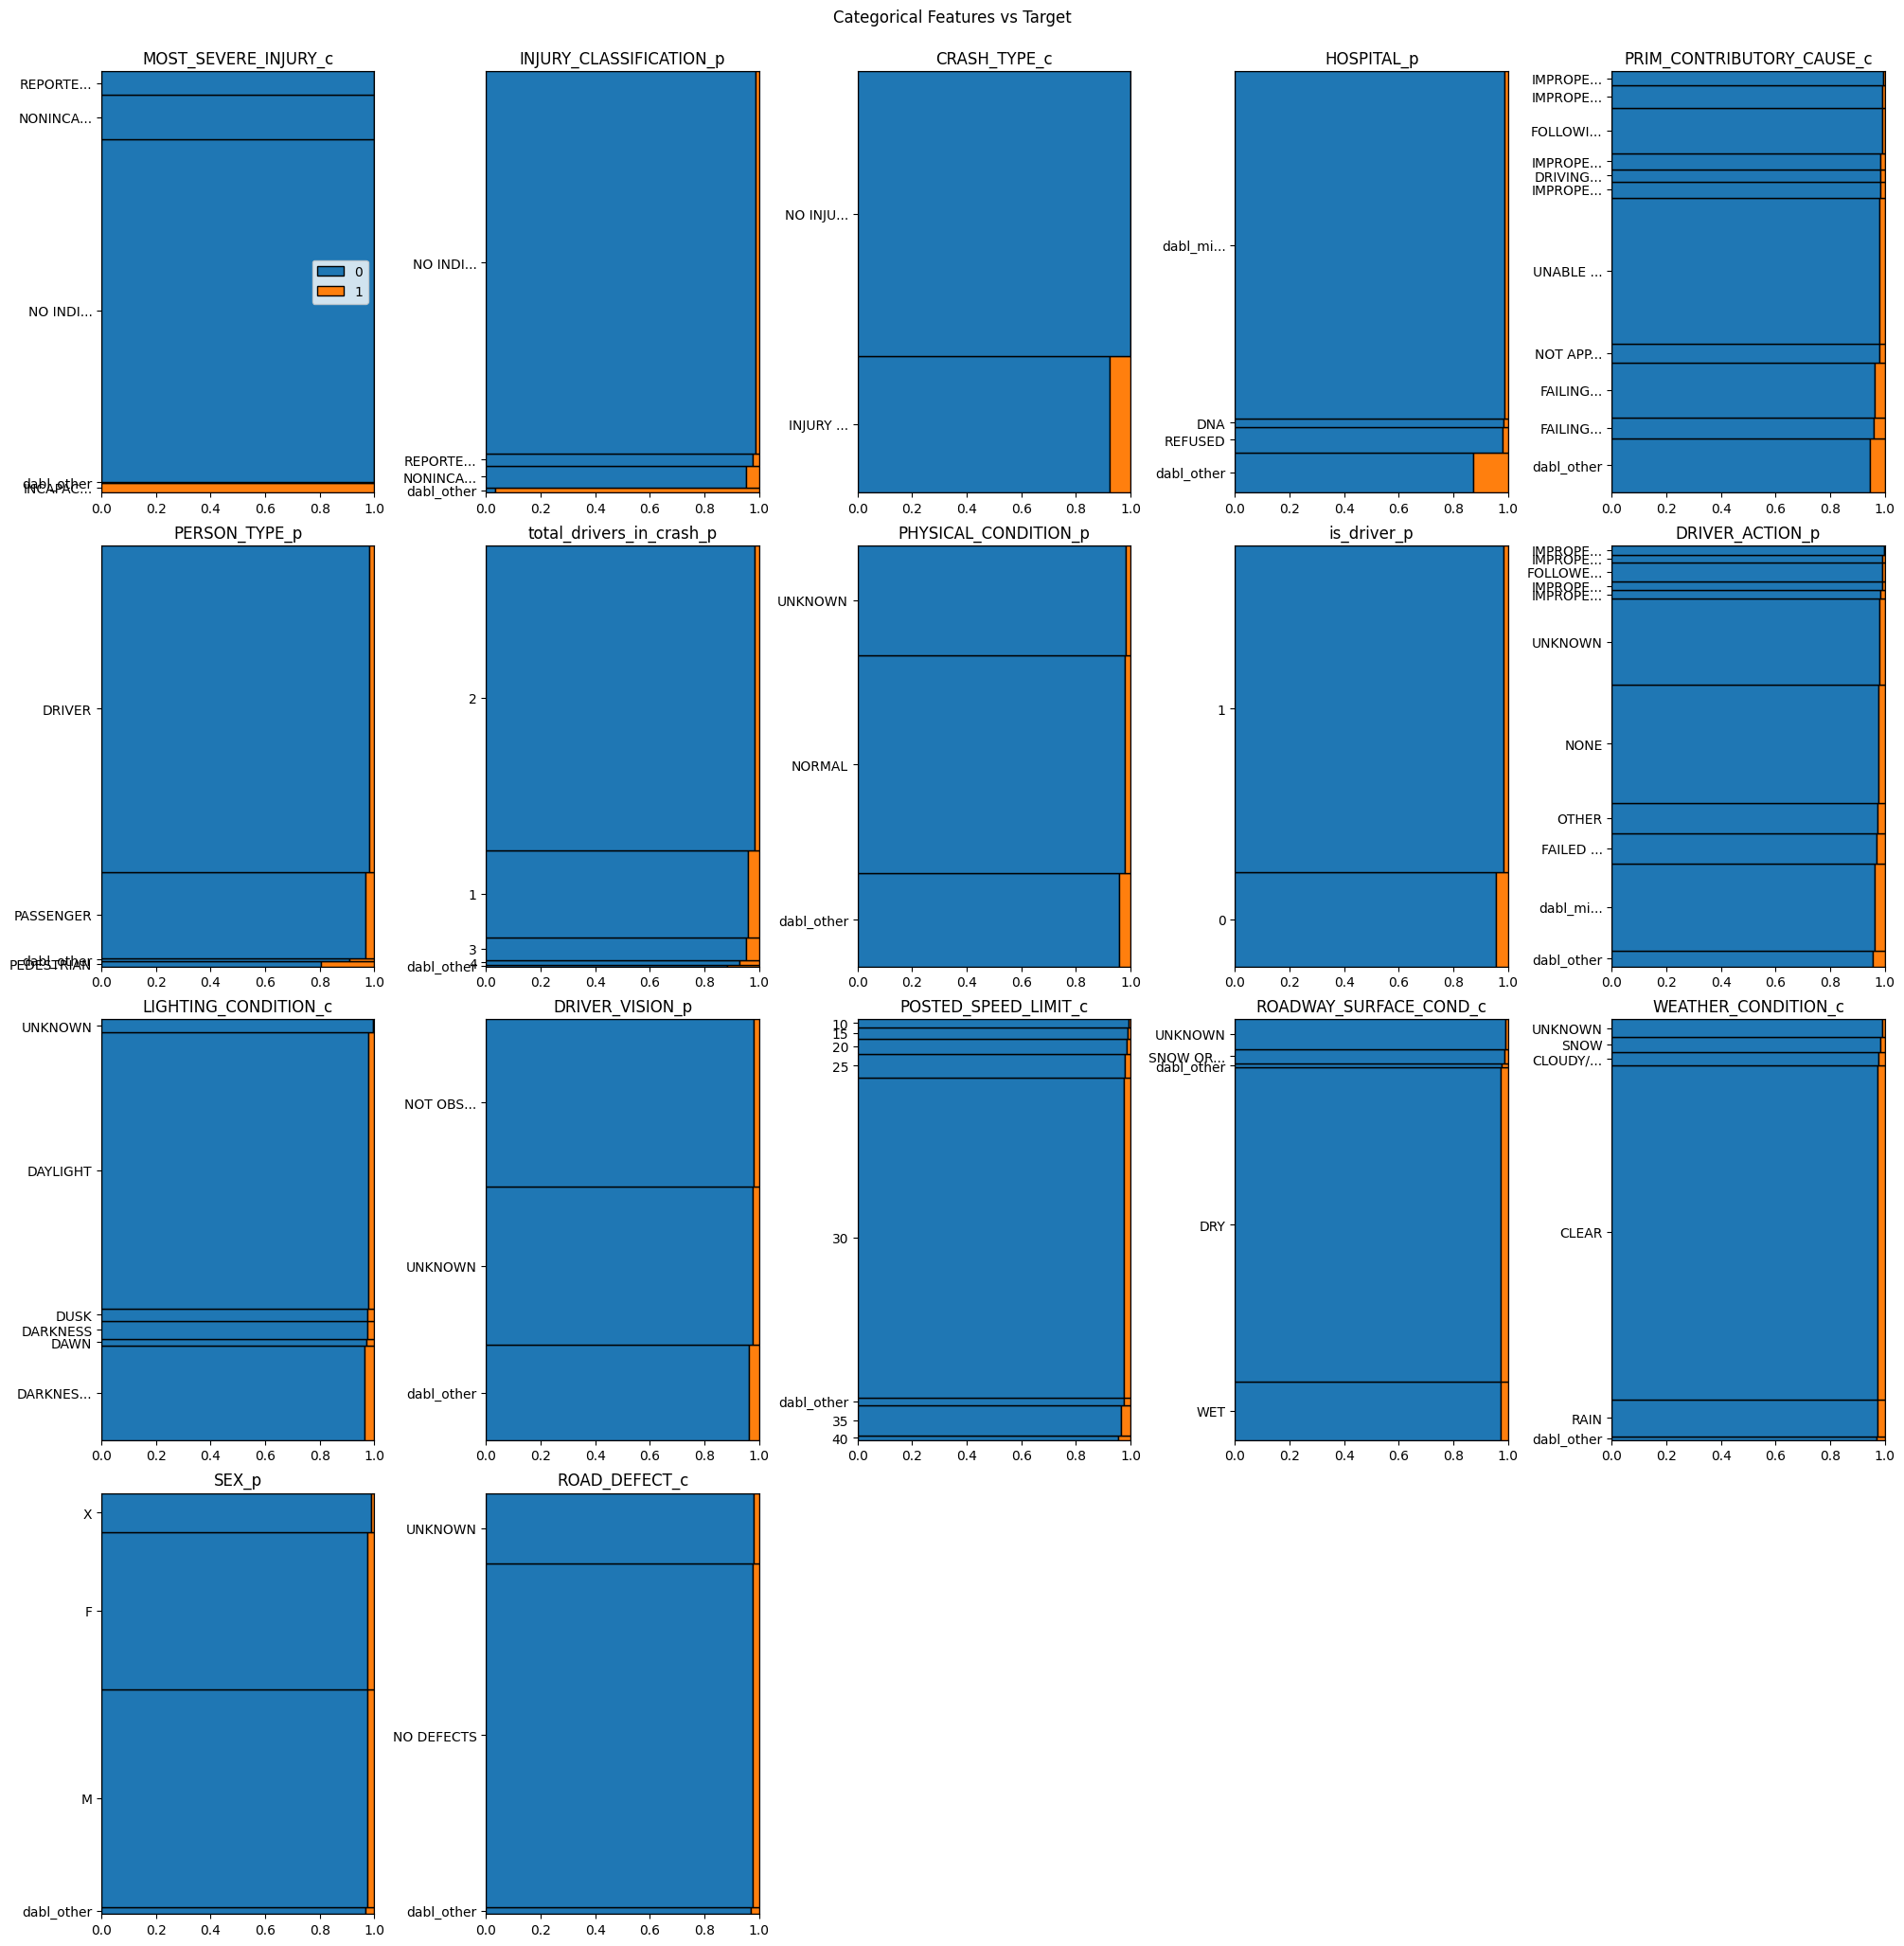

In [ ]:
dabl.plot(data, target_col="Has_Serious_Injury")

#No automated modeling for you!



```
sc = dabl.SimpleClassifier().fit(X_train, y_train)
print("Accuracy score", sc.score(X_test, y_test))
```


```
ec = dabl.SimpleClassifier(random_state=10).fit(data, target_col="Has_Serious_Injury")
```




```
usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
```



##Decision Tree Ideas

* PERSON_TYPE_p
* AGE_p
* PRIM_CONTRIBUTORY_CAUSE_c
* HOUR

In [ ]:
df['CRASH_HOUR_c'].isna().sum()


0

In [ ]:
df['PERSON_TYPE_p'].isna().sum()

0

In [ ]:
df['PRIM_CONTRIBUTORY_CAUSE_c'].isna().sum()

0

In [ ]:
df['AGE_p'].isna().sum()

381881

In [ ]:
# Replace None with appropriate code
from sklearn.impute import MissingIndicator

# (1) Identify data to be transformed
# We only want missing indicators for AGE_p
age_train = X_train[["AGE_p"]]

# (2) Instantiate the transformer object
missing_indicator = MissingIndicator()

# (3) Fit the transformer object on age_train
missing_indicator.fit(age_train)

# (4) Transform age_train and assign the result
# to age_missing_train
age_missing_train = missing_indicator.transform(age_train)


# Visually inspect age_missing_train
age_missing_train

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [ ]:
# (5) add the transformed data to the other data
X_train["AGE_Missing"] = age_missing_train
X_train

,PERSON_ID_p,CRASH_RECORD_ID,VEHICLE_ID_p,CRASH_DATE_p,PERSON_TYPE_p,SEX_p,AGE_p,HOSPITAL_p,INJURY_CLASSIFICATION_p,DRIVER_ACTION_p,...,CRASH_TYPE_c,HIT_AND_RUN_I_c,PRIM_CONTRIBUTORY_CAUSE_c,MOST_SEVERE_INJURY_c,INJURIES_TOTAL_c,INJURIES_FATAL_c,INJURIES_INCAPACITATING_c,LOCATION_c,Total_Serious_Injuries,AGE_Missing
1166740,O1441583,ba4ec8b406efdf214d93b82a9322d6772cf15cf93952ce...,1370082.0,2022-10-15 21:30:00,DRIVER,F,NaN,NaN,NO INDICATION OF INJURY,DISREGARDED CONTROL DEVICES,...,NO INJURY / DRIVE AWAY,NaN,DISREGARDING TRAFFIC SIGNALS,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.633070710665 41.903969211265),0.0,True
409182,O1205258,19f3b1dc9443416ee2e0400793e8cbe8ac0cf4299bfa32...,1143599.0,2021-10-14 16:31:00,DRIVER,M,NaN,NaN,NO INDICATION OF INJURY,UNKNOWN,...,NO INJURY / DRIVE AWAY,NaN,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.63877646775 41.893235453981),0.0,True
364000,O1165227,957ec704fe1f137830212710b600f99ad4c2c071fd7931...,1105342.0,2021-08-19 19:38:00,DRIVER,M,35.0,REFUSED,NO INDICATION OF INJURY,UNKNOWN,...,NO INJURY / DRIVE AWAY,NaN,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.738231316326 41.885385687248),0.0,False
582919,O385692,a8dff103513ee3c39e91db91f4d98b41924ab4587706cb...,373236.0,2018-05-14 09:00:00,DRIVER,X,NaN,NaN,NO INDICATION OF INJURY,UNKNOWN,...,NO INJURY / DRIVE AWAY,Y,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.769496346681 41.924075335814),0.0,True
1273791,O1527417,52ed9115ac9c0a81540cf91e35c599d6a58e4eba3cfc7b...,1452350.0,2023-01-28 13:15:00,DRIVER,F,41.0,NaN,NO INDICATION OF INJURY,FAILED TO YIELD,...,NO INJURY / DRIVE AWAY,NaN,FAILING TO YIELD RIGHT-OF-WAY,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.674282533953 41.881241456803),0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157021,P350789,45d6945902652e2b8e29fdfb5672bc888d69f78396c202...,1509774.0,2023-05-30 14:45:00,PASSENGER,M,33.0,NaN,NO INDICATION OF INJURY,NaN,...,NO INJURY / DRIVE AWAY,NaN,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.616467992662 41.816748565662),0.0,False
804336,O664642,2702f7d94485012cff2940b692e50569977303ecd00c30...,632803.0,2019-06-06 17:45:00,DRIVER,F,52.0,NaN,NO INDICATION OF INJURY,FAILED TO YIELD,...,NO INJURY / DRIVE AWAY,NaN,FAILING TO YIELD RIGHT-OF-WAY,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.709855066197 41.947166208446),0.0,False
1154171,P317989,2a17d34a5887c061ded038d1ca5e1b6f5f3442c33da354...,1361078.0,2022-10-02 10:15:00,PASSENGER,M,75.0,HOLY CROSS,NONINCAPACITATING INJURY,NaN,...,INJURY AND / OR TOW DUE TO CRASH,Y,IMPROPER TURNING/NO SIGNAL,NONINCAPACITATING INJURY,3.0,0.0,0.0,POINT (-87.682703645326 41.750197156207),0.0,False
617841,O429295,422d68bd88826f1cb0999d06d180d7c14348aa6491a6b9...,412139.0,2018-07-09 23:03:00,DRIVER,M,0.0,NaN,NO INDICATION OF INJURY,NONE,...,NO INJURY / DRIVE AWAY,Y,FAILING TO REDUCE SPEED TO AVOID CRASH,NO INDICATION OF INJURY,0.0,0.0,0.0,POINT (-87.722476772821 41.961124962789),0.0,False


In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

imputer.fit(age_train)

age_train_imputed = imputer.transform(age_train)

age_train_imputed

array([[37.81392585],
       [37.81392585],
       [35.        ],
       ...,
       [75.        ],
       [ 0.        ],
       [37.81392585]])

In [ ]:
# categorical variables to use
cat_vars = ['PERSON_TYPE_p', 'PRIM_CONTRIBUTORY_CAUSE_c']

# numerical variables to use
num_vars = ['AGE_p', 'CRASH_HOUR_c']

crash_data = df[cat_vars + num_vars]



In [ ]:
#imputer = SimpleImputer(strategy="median")

In [ ]:
# DATACAMP EXAMPLE KNN

# Create arrays for the features and the target variable
y = churn_df["churn"].values
X = churn_df[["account_length", "customer_service_calls"]].values

# Create a KNN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X, y)


In [ ]:
#DATACAMP EXAMPLE KNN
# Create neighbors
neighbors = np.arange(1, 13)
train_accuracies = {}
test_accuracies = {}

for neighbor in neighbors:

    # Set up a KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=neighbor)

    # Fit the model
    knn.fit(X_train, y_train)

    # Compute accuracy
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)
print(neighbors, '\n', train_accuracies, '\n', test_accuracies)

In [ ]:
selected_columns = ['PERSON_TYPE_p', 'AGE_p', 'PRIM_CONTRIBUTORY_CAUSE_c', 'Has_Serious_Injury']

features_df = df[selected_columns].copy()

##Imputing Notes


*  speed limit - 30
*  drop missing location /latitude longitude
*  no indication of injury
*  sex - mean
*  age - median ?
* BAC result value - median

